# Lesson 6 : EPICS area detector

In this lesson, we'll show how to use the tools provided 
with Bluesky to acquire an image from an EPICS Area Detector 
and show the image in the notebook.

The EPICS Area Detector supports many different kinds of 
detector and  provides many configuration possibilities 
for each detector in addition to configuration for handling 
of the acquired image or image stream via area detector 
components referred to as *plugins*.  Configuration of 
bluesky to use an EPICS Area Detector usually requires 
several steps that are particular to the installation 
of the detector, specifically the type of camera and 
the use of the plugin chain.

The amount of data that comes from imaging 
devices such as area detectors is much larger than the 
data involved with other data acquisition devices such as 
motors, scalers, temperature sensors, etc.  Often, the imaging
cameras will save the image data direct to a file system 
such as local storage.  EPICS Area Detector has plugins to
store the image stream to a file system accessible from the 
IOC (the camera's EPICS server computer).  The Bluesky 
framework is designed with these considerations.  The image
data is stored external to the *databroker* component in 
bluesky.  The *databroker* stores references to the file 
and address and provides access routines for the image data that
manage ease of use along with efficient use of computing resources
(memory, networking, etc.).  

So, instead of reading the image data directly from the 
area detector, we'll configure the area detector plugin chain
to handle the image data and then, if we choose, use the 
databroker to process the image further such as visualize.

**note**:  This tutorial expects to find an EPICS IOC 
on the local network configured as an EPICS AreaDetector 
[`ADSimDetector`](https://github.com/areaDetector/ADSimDetector) 
IOC with prefix `adsky:`.  A docker container is available 
to provide this IOC.  See this URL for instructions:  
https://github.com/prjemian/epics-docker/blob/master/n4_areaDetector/README.md

----

Define the IOC prefix we'll use.

In [1]:
_ad_prefix = "adsky:"

Import the instrument package as our routine initialization.

In [2]:
from instrument.collection import *

I Sat-13:59:03 - ############################################################ startup
I Sat-13:59:03 - logging started
I Sat-13:59:03 - logging level = 10
I Sat-13:59:03 - /home/prjemian/Documents/projects/use_bluesky/lessons/instrument/collection.py
I Sat-13:59:03 - /home/prjemian/Documents/projects/use_bluesky/lessons/instrument/mpl/notebook.py
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/use_bluesky/lessons/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
I Sat-13:59:03 - bluesky framework
I Sat-13:59:03 - /home/prjemian/Documents/projects/use_bluesky/lessons/instrument/framework/check_python.py
I Sat-13:59:03 - /home/prjemian/Documents/projects/use_bluesky/lessons/instrument/framework/check_bluesky.py
I Sat-13:59:04 - /home/prjemian/Documents/projects/use_bluesky/lessons/instrument/framework/initialize.py
I Sat-13:

For this tutorial, we'll configure the plotting as *inline* so we can view the graphics if we run the notebook from sessions in JupyterLab.  For details, https://stackoverflow.com/a/51932652

We always do this step *after* the instrument package has been imported.

In [3]:
%matplotlib inline

The EPICS area detector support in ophyd has many features, some of them specific to the detector make and model.  Let's start with just a few features using the ADSimDetector.  We'll need to import support from ophyd by parts as they are needed.

As we add features from the area detector plugins or other capabilities, the configuration complexity will increase.  So, it is good to start with a simple case where we can control the camera and generate images.

In [4]:
from ophyd import Component
from ophyd.areadetector import ImagePlugin
from ophyd.areadetector import SimDetector
from ophyd.areadetector import SingleTrigger

We need the ophyd `SimDetector` device.  That support is flexible, so we must describe *how* we'll trigger it for data acquisition.  We do that by adding the `SingleTrigger` mixin.  Here's how to do it.  This procedure is typical of what we'll have to do to support almost any EPICS area detector.

In [5]:
class MySingleTriggerSimDetector(SingleTrigger, SimDetector):
    pass

Make an instance of this class and connect it with EPICS.

In [6]:
adsimdet = MySingleTriggerSimDetector(_ad_prefix, name='adsimdet')
adsimdet.wait_for_connection()

**Staging** is fundamental to data acquisition in the Bluesky framework.  Before a device is *triggered* to acquire data, it is *staged* to configure it for that specific acquisition.  After acquisition is complete, the device is *unstaged* so that its previous configuration is restored.  The *RunEngine* (`RE`) takes care of staging and unstaging so this all takes place behind the scenes.  The `RE` also handles this when acquisition is interrupted.

Here, we configure `adsimdet` for acquisition.  These settings will be applied as part of data acquisition, then the previous settings will be restored. Here:

* take one image per acquisition
* acquire for exactly 0.1 seconds
* Each acquisition will return after 0.25 s 

Note: if multiple acquisitions, acquire at interval of `adsimdet.cam.acquire_period`.

In [7]:
adsimdet.stage_sigs["cam.num_images"] = 1
adsimdet.stage_sigs["cam.acquire_time"] = 0.1
adsimdet.stage_sigs["cam.acquire_period"] = 0.25

Show all the settings to be used for data acquisition with this detector.

In [8]:
adsimdet.stage_sigs

OrderedDict([('cam.acquire', 0),
             ('cam.image_mode', 1),
             ('cam.num_images', 1),
             ('cam.acquire_time', 0.1),
             ('cam.acquire_period', 0.25)])

This is a python dictionary.  We have just added to this.  The settings will be applied in the order they have been added, then removed in reverse order after acquisition.  Here's what the first two setting mean.  The others were described above.

:value | :meaning
---- | ----
`cam.acquire` | turn off any acquisition in progress
`cam.image_mode` | use single image mode

Use the *RunEngine* to acquire one image.

In [9]:
RE(bp.count([adsimdet]))



Transient Scan ID: 1     Time: 2020-05-16 13:59:07
Persistent Unique Scan ID: '931f2b22-4f9c-42f2-9921-122caef4d700'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 13:59:07.9 |
+-----------+------------+
generator count ['931f2b22'] (scan num: 1)


('931f2b22-4f9c-42f2-9921-122caef4d700',)

**Display image from EPICS PV data**

As noted above, we do not load the image data directly from EPICS PVs at this point for visualization.  Recommended practice with Bluesky is to handle this large data as an 
external resource using the *databroker*.  The file name and address within the file are 
stored with data acquisition, then *databroker* is used to access the image data.

These next cells show how one might get the image data directly from EPICS.  There
are several additional aspects to consider to visualize an image in this way:

* For large image data, it may be necessary to have defined 
  `EPICS_CA_ARRAY_BYTES` before starting the notebook session 
  *and* having that value set in the IOC.
* Large images may stretch available resources on the computer that visualizes the data.
* For multi-frame data, the image data may be 3-dimensional.
* For a color camera, the image values should consider all colors and data value size.
* The byte order or bit order may be different.

Use of the plugin chain to handle the image data is recommended to handle all these aspects,
simplify client-side software, and avoid writing software that is already written.

First, we would need to add the *image* plugin to our area detector configuration,
then make an instance with this new definition and repeat the configuration steps:

```
class MySingleTriggerSimDetector(SingleTrigger, SimDetector): 
       
    image = Component(ImagePlugin, suffix="image1:")

adsimdet = MySingleTriggerSimDetector(_ad_prefix, name='adsimdet')
adsimdet.wait_for_connection()
adsimdet.stage_sigs["cam.num_images"] = 1
adsimdet.stage_sigs["cam.acquire_time"] = 0.1
adsimdet.stage_sigs["cam.acquire_period"] = 0.25
```

The image comes from EPICS AD as a 1-D array, row by row.
Here, we know it is a 2-D array (in the general case, 
we'd to learn that from EPICS).
To make it into a 2-D array, we first need to
get the number of rows and columns from the image plugin.

```
array_size = adsimdet.image.array_size.get()
shape = (array_size.height, array_size.width)
```

Now, get the image and make it a 2-D array.

```
im = adsimdet.image.array_data.get().reshape(shape)
```

Tell MatPlotLib to show the image.

```
# show the image
plt.imshow(im)
```

You could make these steps into a Python function:

```
def show_ad_image(det):
    array_size = det.image.array_size.get()
    shape = (array_size.height, array_size.width)
    im = det.image.array_data.get().reshape(shape)
    plt.imshow(im)
```

and then call that function:

```
show_ad_image(adsimdet)
```


## Use HDF file saving plugin

Use the EPICS Area Detector HDF (HDF5) File saving plugin to 
save image(s) to HDF5 file.  We'll need more tools from the 
ophyd package to configure the plugin.

In [10]:
from ophyd.areadetector import ADComponent
from ophyd.areadetector import EpicsSignalWithRBV
from ophyd.areadetector import HDF5Plugin
from ophyd.areadetector.filestore_mixins import FileStoreHDF5IterativeWrite

The first thing we need to do is to modify the existing support
since we had a few problems when developing this tutorial.
These steps could be removed when the problems are fixed.

* `create_directory_depth` : Allow access to create subdirectories on demand.
* `array_callbacks` : Reveal in ophyd interface.
* `pool_max_buffers` : remove this attribute (set it to `None` instead of using `del`).
* `get_frames_per_point()` : needed by databroker, 
  returns the number of frames that were received with a 
  single acquisition.

In [11]:
class MyHDF5Plugin(HDF5Plugin, FileStoreHDF5IterativeWrite):
    create_directory_depth = Component(EpicsSignalWithRBV, suffix="CreateDirectory")
    array_callbacks = Component(EpicsSignalWithRBV, suffix="ArrayCallbacks")

    pool_max_buffers = None
    
    def get_frames_per_point(self):
        return self.num_capture.get()

    def stage(self):
        super().stage()
        res_kwargs = {'frame_per_point': self.get_frames_per_point()}
        # res_kwargs = {'frame_per_point': self.num_capture.get()}
        self._generate_resource(res_kwargs)

We're using an IOC that writes to a different file system than our notebook.
Our IOC is running from a docker container.  We tell the HDF5 plugin to write
files to `/tmp/simdet/YEAR/MONTH/DAY/FILENAME.h5` in the IOC's filesystem.
Our docker container mounts that filesystem in directory `/tmp/iocadsky/tmp` to this notebook can access the same files as `/tmp/iocadsky/tmp/simdet/YEAR/MONTH/DAY/FILENAME.h5`.

Databroker is designed to reference the file locations based on a 
directory path relative to some directory.  This allows the collected 
filesystem to be moved to other directories (such as a copy to take home), 
yet still be found by databroker.  To enable this, the ophyd support 
must be able to separate the directory path into base and relocatable parts.

In the setup below, we use three variables to define these parts:

variable | meaning
:---- | :----
`WRITE_HDF5_FILE_PATH` | directory path seen by EPICS area detector IOC
`READ_HDF5_FILE_PATH` | directory path seen by bluesky during data acquisition
`DATABROKER_ROOT_PATH` | base (common part) directory path


In [12]:
DATABROKER_ROOT_PATH = "/tmp/"

# note: AD path MUST, must, MUST have trailing "/"!!!
#  ...and... start with the same path defined in root (above)

# path as seen by detector IOC
WRITE_HDF5_FILE_PATH = "/tmp/simdet/%Y/%m/%d/"
#!!! NOTE !!! This filesystem is on the IOC

# path as seen by bluesky data acquistion
READ_HDF5_FILE_PATH = "/tmp/docker_ioc/iocadsky/tmp/simdet/%Y/%m/%d/"

Re-write our custom detector class to include the HDF File Writing plugin.  Use our custom plugin support since we modified the support.

Also, we have added support for the Image plugin so we can, as is common practice, observe the acquired image with a GUI tool such as ImageJ or caQtDM.  However, those GUI tools are not part of this tutorial.

In [13]:
class MySingleTriggerSimDetector(SingleTrigger, SimDetector): 
       
    image = Component(ImagePlugin, suffix="image1:")
    hdf1 = ADComponent(
        MyHDF5Plugin,
        suffix='HDF1:', 
        root=DATABROKER_ROOT_PATH,
        write_path_template = WRITE_HDF5_FILE_PATH,
        read_path_template = READ_HDF5_FILE_PATH,
    )

Make an instance of this class.  It may not be necessary to add the `wait_for_connection()` command but it is good practice.

We'll need to configure the HDF plugin for image per capture (it does not get this automatically from the `cam` module).

In [14]:
adsimdet = MySingleTriggerSimDetector(_ad_prefix, name='adsimdet')
adsimdet.wait_for_connection()
adsimdet.stage_sigs["cam.num_images"] = 1
adsimdet.stage_sigs["cam.acquire_time"] = 0.1
adsimdet.stage_sigs["cam.acquire_period"] = 0.25
adsimdet.hdf1.stage_sigs["num_capture"] = 1

Show the items that will be staged.

In [15]:
adsimdet.stage_sigs

OrderedDict([('cam.acquire', 0),
             ('cam.image_mode', 1),
             ('cam.num_images', 1),
             ('cam.acquire_time', 0.1),
             ('cam.acquire_period', 0.25)])

In [16]:
adsimdet.hdf1.stage_sigs

OrderedDict([('enable', 1),
             ('auto_increment', 'Yes'),
             ('array_counter', 0),
             ('auto_save', 'Yes'),
             ('num_capture', 1),
             ('file_template', '%s%s_%6.6d.h5'),
             ('file_write_mode', 'Stream'),
             ('capture', 1),
             ('blocking_callbacks', 'Yes'),
             ('parent.cam.array_callbacks', 1)])

Just a bit more configuration of the HDF plugin.  

We add it to the `adsimdet.read_attrs` list so that the HDF plugin returns some useful data when `adsimdet` is read during acquistion (by `adsimdet.read()`).

We allow the HDF plugin to create up to 5 subdirectories when writing the image to an HDF5 file.  We need that since we have built the year, month, and date into the file path.

In [17]:
adsimdet.read_attrs.append("hdf1")
if adsimdet.hdf1.create_directory_depth.get() == 0:
    # probably not set, so let's set it now to some default
    adsimdet.hdf1.create_directory_depth.put(-5)

**Prime the area detector file writing plugin**

EPICS AreaDetector file-saving plugins (such as 
the HDF plugin) must be primed before they can be 
used.  Priming must be done in these situations:

* the IOC has just started
* the image size has changed

If you do not prime the detector and its plugin chain, *ophyd* will report an *UnprimedPlugin* error like this if you try to trigger (acquire data from) the detector:

```
UnprimedPlugin: The plugin hdf1 on the area detector with name DETECTOR_NAME has not been primed.
```

To prime the HDF plugin, call its `warmup()` method.

In [18]:
enabled = adsimdet.hdf1.enable.get()
adsimdet.hdf1.warmup()
adsimdet.hdf1.enable.put(enabled)

Acquire an image and save it to an HDF5 file.  Print out 
the name of the file (on the IOC filesystem).

In [19]:
print(f"frames/point: {adsimdet.hdf1.get_frames_per_point()}")
RE(bp.count([adsimdet]))
print(adsimdet.hdf1.full_file_name.get())

frames/point: 1


Transient Scan ID: 2     Time: 2020-05-16 13:59:12
Persistent Unique Scan ID: 'b761689f-ec6f-44b5-a862-c9b2ceb3d820'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 13:59:12.9 |
+-----------+------------+
generator count ['b761689f'] (scan num: 2)
/tmp/simdet/2020/05/16/ec0e1c0a-6d32-4f06-8606_000000.h5


## Show the image

Now, use *databroker* to retrieve that data and show the image.  We imported the `db` symbol (instance of the *databroker*) with the instrument package.  The most recent data is accessed using a list-style reference.  The symbol `h` is customary to use as a run *header* in reference to the most recent data.

In [20]:
h = db[-1]

Just to be informative, show all the documents from the most recent data.  Look for the *resource* document that describes the details of the image file.

In [21]:
for entry in h.documents():
    key, doc = entry
    print(key, doc)
    print("-"*40)

start 
Run Start
beamline_id     : APS lesson                              
detectors       : ['adsimdet']                            
hints           :
  dimensions      : [[['time'], 'primary']]                 
login_id        : prjemian@poof                           
num_intervals   : 0                                       
num_points      : 1                                       
pid             : 31285                                   
plan_args       :
  detectors       : ["MySingleTriggerSimDetector(prefix='adsky:', name='adsimdet', read_attrs=['hdf1'], configuration_attrs=['cam', 'cam.acquire_period', 'cam.acquire_time', 'cam.image_mode', 'cam.manufacturer', 'cam.model', 'cam.num_exposures', 'cam.trigger_mode', 'hdf1'])"]
  num             : 1                                       
plan_name       : count                                   
plan_type       : generator                               
proposal_id     : testing                                 
scan_id         :

Show the image the last data with matplotlib.

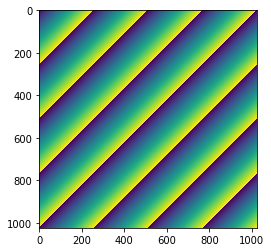

In [22]:
# get the MatPlotLib tool
from instrument.mpl import plt

plt.imshow(h.xarray().adsimdet_image[0][0])

The structure of the HDF5 file as reported by the 
punx program (https://punx.readthedocs.io):

```
  entry:NXentry
    data:NXdata
      data:NX_UINT8[1,1024,1024] = [ ... ]
    instrument:NXinstrument
      NDAttributes:NXcollection
        NDArrayEpicsTSSec:NX_UINT32 = 958492486
        NDArrayEpicsTSnSec:NX_UINT32 = 334947107
        NDArrayTimeStamp:NX_FLOAT64 = 958492486.2348573
        NDArrayUniqueId:NX_INT32 = 3
      detector:NXdetector
        data:NX_UINT8[1,1024,1024] = [ ... ]
        NDAttributes:NXcollection
          ColorMode:NX_INT32 = 0
      performance
        timestamp:NX_FLOAT64[1,5] = [ ... ]
```

With attributes shown:

```
  entry:NXentry
    @NX_class = NXentry
    data:NXdata
      @NX_class = NXdata
      data:NX_UINT8[1,1024,1024] = [ ... ]
        @NDArrayDimBinning = 1
        @NDArrayDimOffset = 0
        @NDArrayDimReverse = 0
        @NDArrayNumDims = 2
        @signal = 1
    instrument:NXinstrument
      @NX_class = NXinstrument
      NDAttributes:NXcollection
        @NX_class = NXcollection
        @hostname = poof
        NDArrayEpicsTSSec:NX_UINT32 = 958492486
          @NDAttrDescription = The NDArray EPICS timestamp seconds past epoch
          @NDAttrName = NDArrayEpicsTSSec
          @NDAttrSource = Driver
          @NDAttrSourceType = NDAttrSourceDriver
        NDArrayEpicsTSnSec:NX_UINT32 = 334947107
          @NDAttrDescription = The NDArray EPICS timestamp nanoseconds
          @NDAttrName = NDArrayEpicsTSnSec
          @NDAttrSource = Driver
          @NDAttrSourceType = NDAttrSourceDriver
        NDArrayTimeStamp:NX_FLOAT64 = 958492486.2348573
          @NDAttrDescription = The timestamp of the NDArray as float64
          @NDAttrName = NDArrayTimeStamp
          @NDAttrSource = Driver
          @NDAttrSourceType = NDAttrSourceDriver
        NDArrayUniqueId:NX_INT32 = 3
          @NDAttrDescription = The unique ID of the NDArray
          @NDAttrName = NDArrayUniqueId
          @NDAttrSource = Driver
          @NDAttrSourceType = NDAttrSourceDriver
      detector:NXdetector
        @NX_class = NXdetector
        data:NX_UINT8[1,1024,1024] = [ ... ]
          @NDArrayDimBinning = 1
          @NDArrayDimOffset = 0
          @NDArrayDimReverse = 0
          @NDArrayNumDims = 2
          @signal = 1
        NDAttributes:NXcollection
          @NX_class = NXcollection
          ColorMode:NX_INT32 = 0
            @NDAttrDescription = Color mode
            @NDAttrName = ColorMode
            @NDAttrSource = Driver
            @NDAttrSourceType = NDAttrSourceDriver
      performance
        timestamp:NX_FLOAT64[1,5] = [ ... ]
```
